In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import glob
from natsort import natsorted

# 한글 글씨체 설정
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.grid'] = False

In [14]:
#https://wooiljeong.github.io/python/naver_datalab_open_api/

def plot_daily_trend(df):
    """
    일 별 검색어 트렌드 그래프 출력
    """
    colList = df.columns[1:]
    n_col = len(colList)

    fig = plt.figure(figsize=(12,6))
    plt.title('일 별 검색어 트렌드', size=20, weight='bold')
    for i in range(n_col):
        sns.lineplot(x=df['날짜'], y=df[colList[i]], label=colList[i])
    plt.legend(loc='upper right')

    return fig

def plot_monthly_trend(df):
    """
    월 별 검색어 트렌드 그래프 출력
    """
    df = df.copy()
    df['날짜'] = df['날짜'].astype('datetime64[ns]')
    df_0 = df.groupby(by=[df['날짜'].dt.year, df['날짜'].dt.month]).mean().droplevel(0).reset_index().rename(columns={'날짜': '월'})
    df_1 = df.groupby(by=[df['날짜'].dt.year, df['날짜'].dt.month]).mean().droplevel(1).reset_index().rename(columns={'날짜': '년도'})

    df = pd.merge(df_1[['년도']], df_0, how='left', left_index=True, right_index=True)
    df['날짜'] = pd.to_datetime(df[['년도','월']].assign(일=1).rename(columns={"년도": "year", "월":'month','일':'day'}))

    colList = df.columns.drop(['날짜','년도','월'])
    n_col = len(colList)

    fig = plt.figure(figsize=(12,6))
    plt.title('월 별 검색어 트렌드', size=20, weight='bold')
    for i in range(n_col):
        sns.lineplot(x=df['날짜'], y=df[colList[i]], label=colList[i])
    plt.legend(loc='upper right')

    return fig

def plot_pred_trend(df, days): #Prophet 예측 모델
    """
    검색어 시계열 트렌드 예측 그래프 출력
    days: 예측일수
    """
    colList = df.columns[1:]
    n_col = len(colList)

    fig_list = []
    for i in range(n_col):

        globals()[f"df_{str(i)}"] = df[['날짜', f'{colList[i]}']]
        globals()[f"df_{str(i)}"] = globals()[f"df_{str(i)}"].rename(columns={'날짜': 'ds', f'{colList[i]}': 'y'})

        m = Prophet()
        m.fit(globals()[f"df_{str(i)}"])

        future = m.make_future_dataframe(periods=days)
        forecast = m.predict(future)
        forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

        globals()[f"fig_{str(i)}"] = m.plot(forecast, figsize=(12,6))
        plt.title(colList[i], size=20, weight='bold')

        fig_list.append(globals()[f"fig_{str(i)}"])

    return fig_list

In [16]:
# 가장 최신파일 불러오기
files = glob.glob('data/result/search_result_relative*.csv')
recent_file = natsorted(seq=files, reverse=True)[0]

df = pd.read_csv(recent_file, encoding='cp949')
df_ = df[['날짜',input('검색어를 입력해주세요: ')]]
#df_ = df[['날짜', '검색어1', '검색어2']]

# 시계열 그래프 작성을 위해 값이 2개 최소 이상인 검색어만 추출하기
#df_ = df[df.columns[df.isnull().sum() < len(df)-1]]

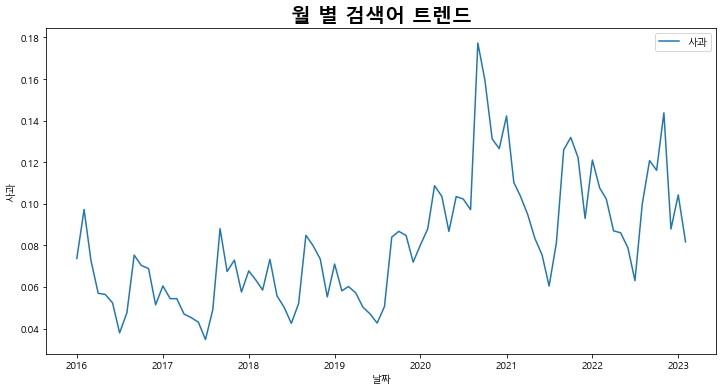

In [4]:
fig_1 = plot_monthly_trend(df_)

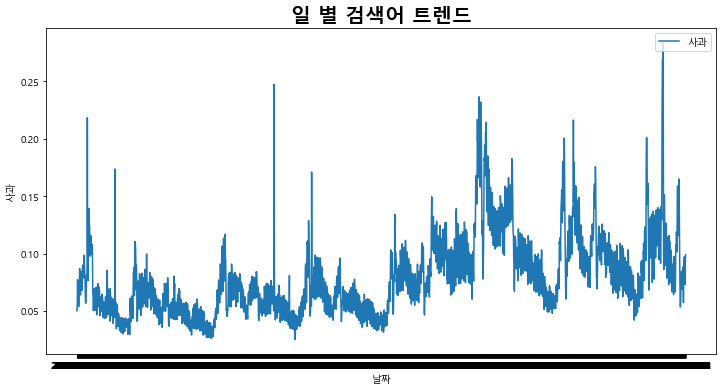

In [18]:
fig_2 = plot_daily_trend(df_)

In [ ]:
# NAN값이 많은 데이터는 예측이 떨어짐. 값이 1개밖에 없는 경우 오류발생
fig_3 = plot_pred_trend(df_, days = 365)